# Import Libraries

In [1]:
from __future__ import print_function
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.txa6yqsd3gcqqc22geq54j2udcxdxhwn.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
best_acc1 = 0
tmp_best_acc1 = 0

### Optimum values found for L1-penalty-weight & L2-weight-decay
    - The appropriate values for l1 & l2 related weights were found after coarsely sweeping thru values from 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001 first.
    - For l1-weight, with l1-alone enabled, the 0.00001 region was found with better values for the validation accuracy vis-a-vis training accuracies.
    - Much finer sweeping in the 0.00001 region, led to the value: 0.000025, which seems to be having best accuracy values.
    - Similarly, For l2-weight,  with l2-alone enabled, the 0.0001 region was found with better values for the validation accuracy vis-a-vis training accuracies.
    - Much finer sweeping in the 0.0001 region, led to the value: 0.0002125, which seems to be having best accuracy values.
    - For individual models, either or both of them will be enabled/disbaled using some related flags defined ahead in this notebook
    - Please note, L2 regaularization implementation is in-built with torch. 

In [3]:
l1_weight = 0.000025 ##Appears to be the best with the reference NW we have used here
l2_weight_decay = 0.0002125 ##Appears to be the best with the reference NW we have used here

In [4]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [5]:
class_names  = [ "zero",  # index 0
                 "one",   # index 1
                 "two",   # index 2 
                 "three", # index 3 
                 "four",  # index 4
                 "five",  # index 5
                 "six",   # index 6 
                 "seven", # index 7 
                 "eight", # index 8 
                 "nine"]  # index 9

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [7]:
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_mnist, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_mnist, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


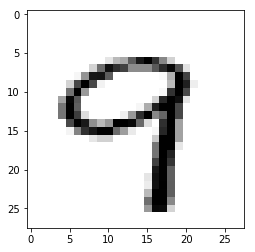

In [9]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_mnist.train_data
train_data = train_mnist.transform(train_data.numpy())
#train_data = train.train_data.cpu().numpy()

print('[Train]')
print(' - Numpy Shape:', train_mnist.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_mnist.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)


plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

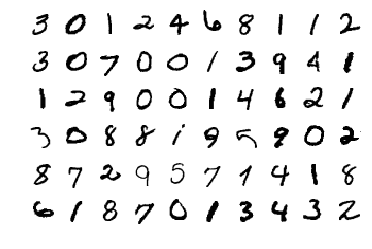

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Training and Testing related routines

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
def l1_penalty(x):
    #L1 regularization adds an L1 penalty equal
    #to the absolute value of the magnitude of coefficients
    return torch.abs(x).sum()

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        #L1 regularization adds an L1 penalty equal to the 
        #absolute value of the magnitude of coefficients
        loss = F.nll_loss(y_pred, target) + l1     
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader, epoch):
    global best_acc1, tmp_best_acc1
    model.eval()
    test_loss = 0
    correct = 0
    acc1 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc1 = 100. * correct / len(test_loader.dataset)
    is_best = acc1 > best_acc1
    tmp_best_acc1 = best_acc1
    best_acc1 = max(acc1, best_acc1)
    # Prepare model model saving directory.
    if is_best:
        save_dir = os.path.join(os.getcwd(), 'saved_models')
        model_name = 'MNIST_model_epoch-{}_L1-{}_L2-{}_val_acc-{}.h5'.format(epoch+1, int(L1), int(L2), acc1) 
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        filepath = os.path.join(save_dir, model_name)
        print("validation-accuracy improved from {} to {}, saving model to {}".format(tmp_best_acc1, best_acc1, filepath))
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filename=filepath)
    test_acc.append(100. * correct / len(test_loader.dataset))

### model-prediction & mislabelled image display related routines


In [12]:
def model_pred(model, device, y_test, batchsize=test_mnist.test_data.cpu().numpy().shape[0]):
    from sklearn.metrics import confusion_matrix, classification_report
    model.eval()
    dataldr_args = dict(shuffle=False, batch_size=batchsize, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=10000)
    test_ldr = torch.utils.data.DataLoader(test_mnist, **dataldr_args)
    with torch.no_grad():
        for data, target in test_ldr:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred = y_pred.cpu().numpy()
    print(confusion_matrix(y_test, y_pred.reshape(-1)))
    print('\n')
    print(classification_report(y_test, y_pred.reshape(-1), target_names=class_names))
    return y_pred


def display_mislabelled(model, device, x_test, y_test, y_pred, title_str):
    fig = plt.figure(figsize=(30,9))
    fig.suptitle(title_str, fontsize=24)
    idx1 = np.where(y_test[:] != y_pred)[0]
    for j in range(3):
        for i in range(len(class_names)):
            ax = fig.add_subplot(3, 10, j*10+i+1, xticks=[], yticks=[])
            idx = np.where(y_test[:] == i)[0]
            intsct = np.intersect1d(idx1, idx)
            features_idx = x_test[intsct, ::]
            img_num = np.random.randint(features_idx.shape[0])
            im = features_idx[img_num]
            ax.set_title('Act:{} '.format(i) + ' Pred:{} '.format(y_pred[intsct[img_num]][0]), fontsize=20)
            plt.imshow(im)
    plt.show()

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


### routine to load any model from saved file

In [13]:
def load_model(describe_model_nn, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    model = describe_model_nn #describe_model_nn is for example: Net1()
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    return  model

### routine to save & load the validation-accuracy & validation-loss data  for any model

In [14]:
def save_acc_loss(test_losses, test_acc, test_loss_file_name,  test_acc_file_name):
    import os
    import numpy as np
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath_test_loss  = os.path.join(save_dir, test_loss_file_name)
    filepath_test_acc  = os.path.join(save_dir, test_acc_file_name)
    np.save(filepath_test_loss,test_losses)
    np.save(filepath_test_acc,test_acc)
    

def load_acc_loss(test_loss_file_name,  test_acc_file_name):
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath_test_loss  = os.path.join(save_dir, test_loss_file_name)
    filepath_test_acc  = os.path.join(save_dir, test_acc_file_name)
    loaded_test_losses = np.load(filepath_test_loss).tolist()
    loaded_test_acc = np.load(filepath_test_acc).tolist()
    return loaded_test_losses, loaded_test_acc

### routine to plot 4 accuracies and 4 losses in 2 separate plots

In [40]:
def plot_curves(first_acc, second_acc, third_acc, fourth_acc,
                first_loss, second_loss, third_loss, fourth_loss):
    fig, axs = plt.subplots(1,2,figsize=(20,10))
    _= axs[0].plot(first_acc)
    _= axs[0].plot(second_acc)
    _= axs[0].plot(third_acc)
    _= axs[0].plot(fourth_acc)
    _= axs[0].set_title('model test accuracies', fontsize=22)
    _= axs[0].set_ylabel('test-accuracy', fontsize=18)
    _= axs[0].set_xlabel('epoch', fontsize=18)
    _= axs[0].legend(['without L1 & L2', 'with L1 alone', 'with L2 alone', 'with both L1 & L2'], loc='upper left')
    _= axs[1].plot(first_loss)
    _= axs[1].plot(second_loss)
    _= axs[1].plot(third_loss)
    _= axs[1].plot(fourth_loss)
    _= axs[1].set_title('model test losses', fontsize=22)
    _= axs[1].set_ylabel('test-loss', fontsize=18)
    _= axs[1].set_xlabel('epoch', fontsize=18)
    _= axs[1].legend(['without L1 & L2', 'with L1 alone', 'with L2 alone', 'with both L1 & L2'], loc='upper right')

# The model
Let's start with the model we first saw, the base-line/refernce model being used here is as shown in the table below:
Please note that my earlier assignment's 5th model had a learning rate-step-LR based change in learning rate, to enter a crevice of higher accuracy within 15 epochs.The same if used as a baseline will have this extra LR as a variable.The effects of L1 & L2 penalties would not be obvious for that earlier NW, hence am starting out with the 3rd Stable NW from assignment-5


Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`  **Input Block** [1 conv2d 3x3 layer]    
` `              | `BN(8)`   |      ` `  |      ` `
` `              | `Dropout(10%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
`26x26x8`             | `(3x3x8)x8`  |      `24x24x8` |      `5x5`     **CONVOLUTION BLOCK 1** [1 conv2d 3x3 layer ]
` `              | `BN(8)`   |      ` `  |      ` `
` `              | `Dropout(10%)`   |      ` `  |      ` `
` `              | `ReLU`   |      ` `  |      ` ` 
**24x24x8**             |   **MP(2x2)**    |     **12x12x8**   |     **6x6**  **TRANSITION BLOCK 1**  [1 maxpool(2,2) & 1 conv2d 1x1 layers]                     
**12x12x8**             | **(1x1x8)x8**  |     **12x12x8**   |      **6x6** 
** **             | **Dropout(10%)**   |     ** **  |     ** **
** **             | **BN(8)**   |     ** **  |     ** **
** **             | **ReLU**   |     ** **  |     ** **      
*12x12x8*             | *(3x3x8)x16*  |      *10x10x16* |      *10x10*  **CONVOLUTION BLOCK 2** [4 conv2d 3x3 layers]
** **            | *BN(16)*   |     * *   |     * * 
** **             | *Dropout(10%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **                       
*10x10x16*             | *(3x3x16)x16*  |      *8x8x16* |      *14x14* 
** **            | *BN(16)*   |     * *   10%|     * * 
** **             | *Dropout(10%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **    
*8x8x16*               | *(3x3x16)x16*  |      *6x6x16*  |      *18x18* 
** **            | *BN(16)*   |     * *   |     * * 
** **             | *Dropout(10%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **   
*6x6x16*               | *(3x3x16)x20*  |      *6x6x20*  |      *22x22* (**Note 1:** o/p channels should be generated after *padding* here, hence you see *6x6* rather than 4x4.In terms of accuracy for 4x4 vs 6x6, it comes out to be better for 6x6, hence padding recommended here.   **Note 2:** also note that this 4x4 vs 6x6 has significance for the upcoming grad-cam assisted visualizations)
** **            | *BN(20)*   |     * *   |     * * 
** **             | *Dropout(10%)*   |     * *   |     * * 
** **             | *ReLU*   |     ** **  |    ** **   
6x6x20               | GAP  LAYER (kernel_size=(6,6)   |      1x1x20          | `32x32` (22 + (6-1)x2 = 32)**OUTPUT BLOCK** [GAP + 1 conv2d 1x1 layer]
`1x1x20`               | `(1x1x20)x10`  |      `1x1x10`    |      ` `  (NO RELU at the o/p of this layer) 
` `             | `log_SoftMax`   |     ` `  |     ` ` 

# 1. model,  40 epochs, without L1/L2

In [13]:
L1 = False #without L1-penalty 
L2 = False #without L2-penalty

In [14]:
dropout_value = 0.1
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [15]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model1 = Net1().to(device)
summary(model1, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Let's Train and test our model

In [16]:
model1 =  Net1().to(device)
#Enable L2-regularization with supplied value of weight decay, or keep it default-0
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model1, device, train_loader, optimizer, epoch)
    test(model1, device, test_loader, epoch)

EPOCH: 1


Loss=0.17729945480823517 Batch_id=937 Accuracy=87.32: 100%|██████████████████████████| 938/938 [00:14<00:00, 71.28it/s]



Test set: Average loss: 0.0538, Accuracy: 9859/10000 (98.59%)

validation-accuracy improved from 0 to 98.59, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-1_L1-0_L2-0_val_acc-98.59.h5
EPOCH: 2


Loss=0.018293380737304688 Batch_id=937 Accuracy=97.41: 100%|█████████████████████████| 938/938 [00:15<00:00, 60.10it/s]



Test set: Average loss: 0.0364, Accuracy: 9889/10000 (98.89%)

validation-accuracy improved from 98.59 to 98.89, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-2_L1-0_L2-0_val_acc-98.89.h5
EPOCH: 3


Loss=0.16337533295154572 Batch_id=937 Accuracy=97.85: 100%|██████████████████████████| 938/938 [00:15<00:00, 61.30it/s]



Test set: Average loss: 0.0318, Accuracy: 9894/10000 (98.94%)

validation-accuracy improved from 98.89 to 98.94, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-3_L1-0_L2-0_val_acc-98.94.h5
EPOCH: 4


Loss=0.02247653901576996 Batch_id=937 Accuracy=98.09: 100%|██████████████████████████| 938/938 [00:15<00:00, 60.67it/s]



Test set: Average loss: 0.0323, Accuracy: 9903/10000 (99.03%)

validation-accuracy improved from 98.94 to 99.03, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-4_L1-0_L2-0_val_acc-99.03.h5
EPOCH: 5


Loss=0.10853263735771179 Batch_id=937 Accuracy=98.28: 100%|██████████████████████████| 938/938 [00:15<00:00, 58.70it/s]



Test set: Average loss: 0.0277, Accuracy: 9916/10000 (99.16%)

validation-accuracy improved from 99.03 to 99.16, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-5_L1-0_L2-0_val_acc-99.16.h5
EPOCH: 6


Loss=0.007745310664176941 Batch_id=937 Accuracy=98.40: 100%|█████████████████████████| 938/938 [00:16<00:00, 57.46it/s]



Test set: Average loss: 0.0248, Accuracy: 9929/10000 (99.29%)

validation-accuracy improved from 99.16 to 99.29, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-6_L1-0_L2-0_val_acc-99.29.h5
EPOCH: 7


Loss=0.23932287096977234 Batch_id=937 Accuracy=98.52: 100%|██████████████████████████| 938/938 [00:15<00:00, 69.43it/s]



Test set: Average loss: 0.0264, Accuracy: 9933/10000 (99.33%)

validation-accuracy improved from 99.29 to 99.33, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-7_L1-0_L2-0_val_acc-99.33.h5
EPOCH: 8


Loss=0.08381284028291702 Batch_id=937 Accuracy=98.57: 100%|██████████████████████████| 938/938 [00:15<00:00, 59.40it/s]



Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.004565820097923279 Batch_id=937 Accuracy=98.63: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.30it/s]



Test set: Average loss: 0.0231, Accuracy: 9935/10000 (99.35%)

validation-accuracy improved from 99.33 to 99.35, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-9_L1-0_L2-0_val_acc-99.35.h5
EPOCH: 10


Loss=0.010620132088661194 Batch_id=937 Accuracy=98.67: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.04it/s]



Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.021225929260253906 Batch_id=937 Accuracy=98.75: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.60it/s]



Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.07156933844089508 Batch_id=937 Accuracy=98.83: 100%|██████████████████████████| 938/938 [00:15<00:00, 58.95it/s]



Test set: Average loss: 0.0256, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.015964046120643616 Batch_id=937 Accuracy=98.82: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.05it/s]



Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.029316484928131104 Batch_id=937 Accuracy=98.82: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.07it/s]



Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.13134844601154327 Batch_id=937 Accuracy=98.84: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.53it/s]



Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

validation-accuracy improved from 99.35 to 99.39, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-15_L1-0_L2-0_val_acc-99.39.h5
EPOCH: 16


Loss=0.0280226469039917 Batch_id=937 Accuracy=98.88: 100%|███████████████████████████| 938/938 [00:15<00:00, 58.84it/s]



Test set: Average loss: 0.0218, Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.001463368535041809 Batch_id=937 Accuracy=98.91: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.52it/s]



Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.11779873073101044 Batch_id=937 Accuracy=98.89: 100%|██████████████████████████| 938/938 [00:16<00:00, 68.46it/s]



Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

validation-accuracy improved from 99.39 to 99.44, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-18_L1-0_L2-0_val_acc-99.44.h5
EPOCH: 19


Loss=0.05132409930229187 Batch_id=937 Accuracy=98.92: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.13it/s]



Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.015259742736816406 Batch_id=937 Accuracy=98.95: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.03it/s]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.009427860379219055 Batch_id=937 Accuracy=98.98: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.36it/s]



Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)

validation-accuracy improved from 99.44 to 99.46, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-21_L1-0_L2-0_val_acc-99.46.h5
EPOCH: 22


Loss=0.0031728893518447876 Batch_id=937 Accuracy=98.97: 100%|████████████████████████| 938/938 [00:15<00:00, 58.93it/s]



Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.0008665472269058228 Batch_id=937 Accuracy=99.02: 100%|████████████████████████| 938/938 [00:16<00:00, 58.24it/s]



Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.03610113263130188 Batch_id=937 Accuracy=98.96: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.42it/s]



Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.05498834699392319 Batch_id=937 Accuracy=99.05: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.38it/s]



Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Loss=0.002268746495246887 Batch_id=937 Accuracy=99.00: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.18it/s]



Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 27


Loss=0.15763697028160095 Batch_id=937 Accuracy=99.06: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.19it/s]



Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.004007384181022644 Batch_id=937 Accuracy=98.97: 100%|█████████████████████████| 938/938 [00:15<00:00, 58.79it/s]



Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 29


Loss=0.0026910901069641113 Batch_id=937 Accuracy=99.05: 100%|████████████████████████| 938/938 [00:15<00:00, 59.37it/s]



Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 30


Loss=0.0035785138607025146 Batch_id=937 Accuracy=99.05: 100%|████████████████████████| 938/938 [00:16<00:00, 56.79it/s]



Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

EPOCH: 31


Loss=0.019674211740493774 Batch_id=937 Accuracy=99.06: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.35it/s]



Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 32


Loss=0.011376559734344482 Batch_id=937 Accuracy=99.08: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.60it/s]



Test set: Average loss: 0.0195, Accuracy: 9929/10000 (99.29%)

EPOCH: 33


Loss=0.004858359694480896 Batch_id=937 Accuracy=99.09: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.49it/s]



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 34


Loss=0.08384636044502258 Batch_id=937 Accuracy=99.09: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.06it/s]



Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)

EPOCH: 35


Loss=0.013647317886352539 Batch_id=937 Accuracy=99.14: 100%|█████████████████████████| 938/938 [00:16<00:00, 56.35it/s]



Test set: Average loss: 0.0182, Accuracy: 9935/10000 (99.35%)

EPOCH: 36


Loss=0.043031543493270874 Batch_id=937 Accuracy=99.09: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.49it/s]



Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Loss=0.020490631461143494 Batch_id=937 Accuracy=99.14: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.18it/s]



Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 38


Loss=0.011505022644996643 Batch_id=937 Accuracy=99.14: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.00it/s]



Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 39


Loss=0.010575994849205017 Batch_id=937 Accuracy=99.12: 100%|█████████████████████████| 938/938 [00:15<00:00, 58.76it/s]



Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

EPOCH: 40


Loss=0.00990806519985199 Batch_id=937 Accuracy=99.11: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.71it/s]



Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

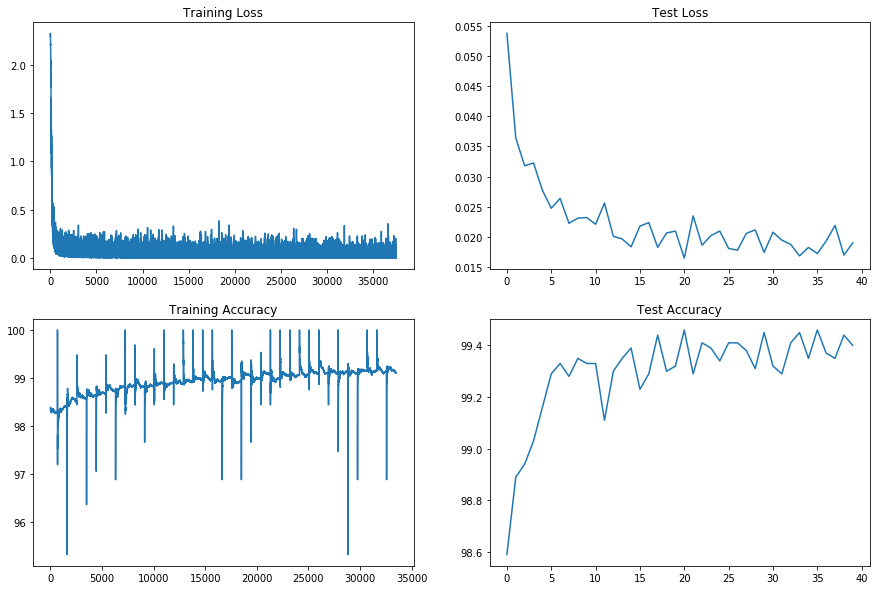

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### save the validation-accuracy & validation-loss data  for the  model without L1/L2

In [45]:
save_acc_loss(test_losses, 
              test_acc, 
              test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
              test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
             )

### an example load for the validation-accuracy & validation-loss data  for the  model without L1/L2
        - Once having saved as a file, these acc/loss values can be loaded anytime

In [48]:
#Load these data points later using code as below
test_loss_l1_0_l2_0, test_acc_l1_0_l2_0 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

Text(0.5, 1.0, 'Test Loss')

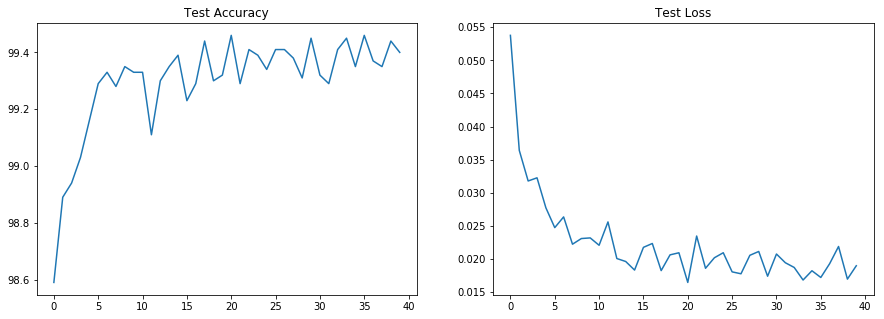

In [64]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_acc_l1_0_l2_0)
axs[0].set_title("Test Accuracy")
axs[1].plot(test_loss_l1_0_l2_0)
axs[1].set_title("Test Loss")

### an example load of  the  model without L1/L2
        - Once having saved as a file, these best model can be loaded anytime, by giving the name

In [54]:
model = load_model(Net1(), model_name='MNIST_model_epoch-21_L1-0_L2-0_val_acc-99.46.h5')

### confusion matrix & classification-report for this model prdection
        - load the best model as above and get the predictions

In [55]:
y_test = test_mnist.test_labels.cpu().numpy()
y_pred = model_pred(model, device, y_test)

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1133    0    1    0    0    0    1    0    0]
 [   2    0 1028    0    0    0    0    2    0    0]
 [   0    0    0 1007    0    3    0    0    0    0]
 [   0    1    0    0  977    0    0    0    1    3]
 [   1    0    0    5    0  885    1    0    0    0]
 [   4    3    0    0    0    1  950    0    0    0]
 [   0    3    4    0    0    0    0 1020    0    1]
 [   0    1    1    0    0    1    0    0  970    1]
 [   1    0    1    0    3    2    0    3    1  998]]


              precision    recall  f1-score   support

        zero       0.99      1.00      0.99       980
         one       0.99      1.00      1.00      1135
         two       0.99      1.00      1.00      1032
       three       0.99      1.00      1.00      1010
        four       1.00      0.99      1.00       982
        five       0.99      0.99      0.99       892
         six       1.00      0.99      0.99       958
       seven       0.99      0.99 

### mislabelled images from the model without L1&L2
        - load the best model as above and get the predictions

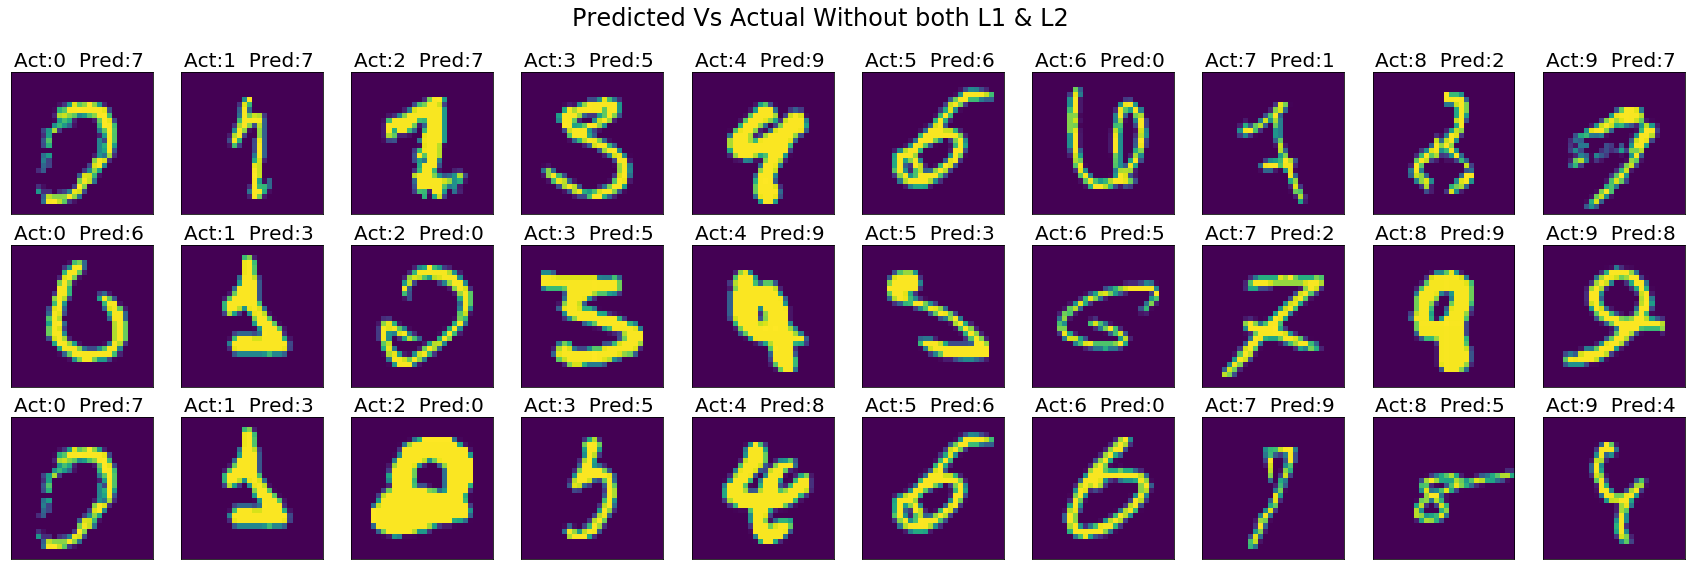

In [60]:
x_test = test_mnist.test_data.cpu().numpy()
display_mislabelled(model, device,  x_test, y_test.reshape(-1,1), y_pred, title_str='Predicted Vs Actual Without both L1 & L2' )

# 2.  model,  40 epochs, with L1 alone

In [15]:
L1 = True #with L1-penalty 
L2 = False #without L2-penalty

#### Though the underlying structure of the models is same for all, am describing each as Net1(), Net2() etc to segregate

In [16]:
dropout_value = 0.1
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [17]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model2 = Net2().to(device)
summary(model2, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Let's Train and test our model

In [18]:
model2 =  Net2().to(device)
#Enable L2-regularization with supplied value of weight decay, or keep it default-0
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model2, device, train_loader, optimizer, epoch)
    test(model2, device, test_loader, epoch)

EPOCH: 1


Loss=0.20852966606616974 Batch_id=937 Accuracy=87.28: 100%|██████████████████████████| 938/938 [00:15<00:00, 61.84it/s]



Test set: Average loss: 0.0553, Accuracy: 9850/10000 (98.50%)

validation-accuracy improved from 0 to 98.5, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-1_L1-1_L2-0_val_acc-98.5.h5
EPOCH: 2


Loss=0.027713611721992493 Batch_id=937 Accuracy=97.35: 100%|█████████████████████████| 938/938 [00:15<00:00, 60.47it/s]



Test set: Average loss: 0.0388, Accuracy: 9887/10000 (98.87%)

validation-accuracy improved from 98.5 to 98.87, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-2_L1-1_L2-0_val_acc-98.87.h5
EPOCH: 3


Loss=0.17234739661216736 Batch_id=937 Accuracy=97.89: 100%|██████████████████████████| 938/938 [00:15<00:00, 62.52it/s]



Test set: Average loss: 0.0346, Accuracy: 9892/10000 (98.92%)

validation-accuracy improved from 98.87 to 98.92, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-3_L1-1_L2-0_val_acc-98.92.h5
EPOCH: 4


Loss=0.01669575273990631 Batch_id=937 Accuracy=98.13: 100%|██████████████████████████| 938/938 [00:15<00:00, 70.09it/s]



Test set: Average loss: 0.0306, Accuracy: 9911/10000 (99.11%)

validation-accuracy improved from 98.92 to 99.11, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-4_L1-1_L2-0_val_acc-99.11.h5
EPOCH: 5


Loss=0.09858770668506622 Batch_id=937 Accuracy=98.32: 100%|██████████████████████████| 938/938 [00:15<00:00, 59.04it/s]



Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

validation-accuracy improved from 99.11 to 99.17, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-5_L1-1_L2-0_val_acc-99.17.h5
EPOCH: 6


Loss=0.010063961148262024 Batch_id=937 Accuracy=98.34: 100%|█████████████████████████| 938/938 [00:15<00:00, 60.02it/s]



Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

validation-accuracy improved from 99.17 to 99.24, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-6_L1-1_L2-0_val_acc-99.24.h5
EPOCH: 7


Loss=0.1962592452764511 Batch_id=937 Accuracy=98.53: 100%|███████████████████████████| 938/938 [00:15<00:00, 59.13it/s]



Test set: Average loss: 0.0245, Accuracy: 9929/10000 (99.29%)

validation-accuracy improved from 99.24 to 99.29, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-7_L1-1_L2-0_val_acc-99.29.h5
EPOCH: 8


Loss=0.08289717137813568 Batch_id=937 Accuracy=98.53: 100%|██████████████████████████| 938/938 [00:15<00:00, 61.42it/s]



Test set: Average loss: 0.0238, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.0048316121101379395 Batch_id=937 Accuracy=98.61: 100%|████████████████████████| 938/938 [00:15<00:00, 59.68it/s]



Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.037777259945869446 Batch_id=937 Accuracy=98.67: 100%|█████████████████████████| 938/938 [00:15<00:00, 58.74it/s]



Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

validation-accuracy improved from 99.29 to 99.38, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-10_L1-1_L2-0_val_acc-99.38.h5
EPOCH: 11


Loss=0.018564805388450623 Batch_id=937 Accuracy=98.72: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.40it/s]



Test set: Average loss: 0.0233, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.0806296169757843 Batch_id=937 Accuracy=98.76: 100%|███████████████████████████| 938/938 [00:16<00:00, 57.12it/s]



Test set: Average loss: 0.0221, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.016385480761528015 Batch_id=937 Accuracy=98.82: 100%|█████████████████████████| 938/938 [00:15<00:00, 67.57it/s]



Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.05296812951564789 Batch_id=937 Accuracy=98.79: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.25it/s]



Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

validation-accuracy improved from 99.38 to 99.48, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-14_L1-1_L2-0_val_acc-99.48.h5
EPOCH: 15


Loss=0.1821618676185608 Batch_id=937 Accuracy=98.84: 100%|███████████████████████████| 938/938 [00:16<00:00, 56.13it/s]



Test set: Average loss: 0.0182, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Loss=0.024349242448806763 Batch_id=937 Accuracy=98.88: 100%|█████████████████████████| 938/938 [00:16<00:00, 56.56it/s]



Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.0014552772045135498 Batch_id=937 Accuracy=98.88: 100%|████████████████████████| 938/938 [00:17<00:00, 54.26it/s]



Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.06390822678804398 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:16<00:00, 59.90it/s]



Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.023395538330078125 Batch_id=937 Accuracy=98.94: 100%|█████████████████████████| 938/938 [00:15<00:00, 67.11it/s]



Test set: Average loss: 0.0198, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.04736095666885376 Batch_id=937 Accuracy=98.91: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.46it/s]



Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


Loss=0.009976714849472046 Batch_id=937 Accuracy=98.95: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.95it/s]



Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 22


Loss=0.0037062466144561768 Batch_id=937 Accuracy=98.92: 100%|████████████████████████| 938/938 [00:15<00:00, 60.97it/s]



Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 23


Loss=0.0009896010160446167 Batch_id=937 Accuracy=99.03: 100%|████████████████████████| 938/938 [00:14<00:00, 64.47it/s]



Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.08320266008377075 Batch_id=937 Accuracy=98.97: 100%|██████████████████████████| 938/938 [00:14<00:00, 64.77it/s]



Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 25


Loss=0.013092577457427979 Batch_id=937 Accuracy=99.03: 100%|█████████████████████████| 938/938 [00:14<00:00, 63.82it/s]



Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


Loss=0.005409806966781616 Batch_id=937 Accuracy=99.01: 100%|█████████████████████████| 938/938 [00:16<00:00, 57.53it/s]



Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 27


Loss=0.12744630873203278 Batch_id=937 Accuracy=99.02: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.59it/s]



Test set: Average loss: 0.0163, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.026747390627861023 Batch_id=937 Accuracy=98.99: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.17it/s]



Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 29


Loss=0.00928497314453125 Batch_id=937 Accuracy=99.06: 100%|██████████████████████████| 938/938 [00:15<00:00, 58.86it/s]



Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Loss=0.003115236759185791 Batch_id=937 Accuracy=99.09: 100%|█████████████████████████| 938/938 [00:15<00:00, 68.97it/s]



Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.02809956669807434 Batch_id=937 Accuracy=99.04: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.52it/s]



Test set: Average loss: 0.0179, Accuracy: 9939/10000 (99.39%)

EPOCH: 32


Loss=0.02557818591594696 Batch_id=937 Accuracy=99.05: 100%|██████████████████████████| 938/938 [00:15<00:00, 59.09it/s]



Test set: Average loss: 0.0166, Accuracy: 9940/10000 (99.40%)

EPOCH: 33


Loss=0.003194078803062439 Batch_id=937 Accuracy=99.05: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.02it/s]



Test set: Average loss: 0.0164, Accuracy: 9953/10000 (99.53%)

validation-accuracy improved from 99.48 to 99.53, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-33_L1-1_L2-0_val_acc-99.53.h5
EPOCH: 34


Loss=0.1023746207356453 Batch_id=937 Accuracy=99.05: 100%|███████████████████████████| 938/938 [00:16<00:00, 58.37it/s]



Test set: Average loss: 0.0163, Accuracy: 9952/10000 (99.52%)

EPOCH: 35


Loss=0.008715063333511353 Batch_id=937 Accuracy=99.15: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.34it/s]



Test set: Average loss: 0.0177, Accuracy: 9940/10000 (99.40%)

EPOCH: 36


Loss=0.03446616232395172 Batch_id=937 Accuracy=99.05: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.34it/s]



Test set: Average loss: 0.0154, Accuracy: 9952/10000 (99.52%)

EPOCH: 37


Loss=0.00693783164024353 Batch_id=937 Accuracy=99.14: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.31it/s]



Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

EPOCH: 38


Loss=0.08594709634780884 Batch_id=937 Accuracy=99.06: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.21it/s]



Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 39


Loss=0.018868789076805115 Batch_id=937 Accuracy=99.14: 100%|█████████████████████████| 938/938 [00:15<00:00, 58.84it/s]



Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

EPOCH: 40


Loss=0.006752759218215942 Batch_id=937 Accuracy=99.17: 100%|█████████████████████████| 938/938 [00:16<00:00, 57.99it/s]



Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

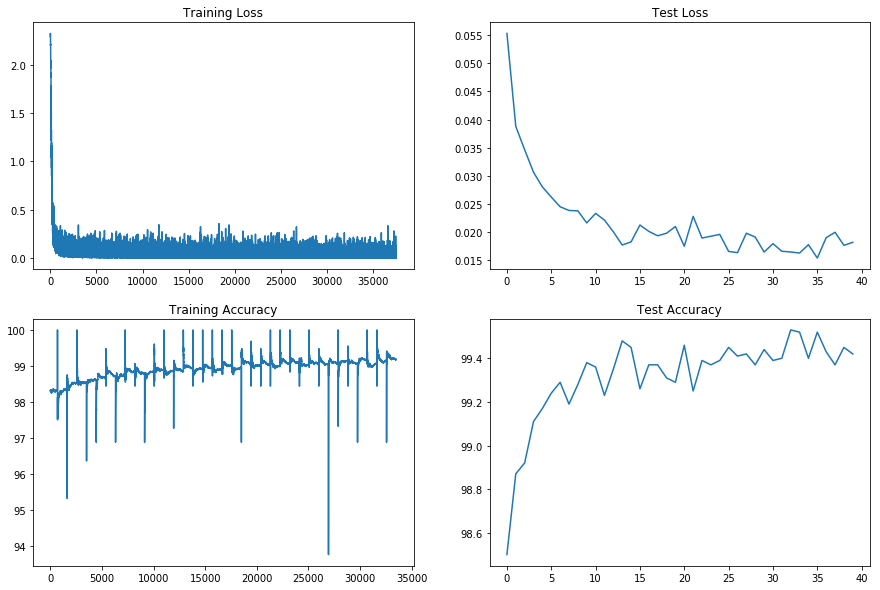

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### save the validation-accuracy & validation-loss data  for the  model with L1 alone

In [23]:
save_acc_loss(test_losses, 
              test_acc, 
              test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
              test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
             )

### an example load for the validation-accuracy & validation-loss data  for the  model with L1 alone
        - Once having saved as a file, these acc/loss values can be loaded anytime

In [24]:
#Load these data points later using code as below
test_loss_l1_1_l2_0, test_acc_l1_1_l2_0 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

Text(0.5, 1.0, 'Test Loss')

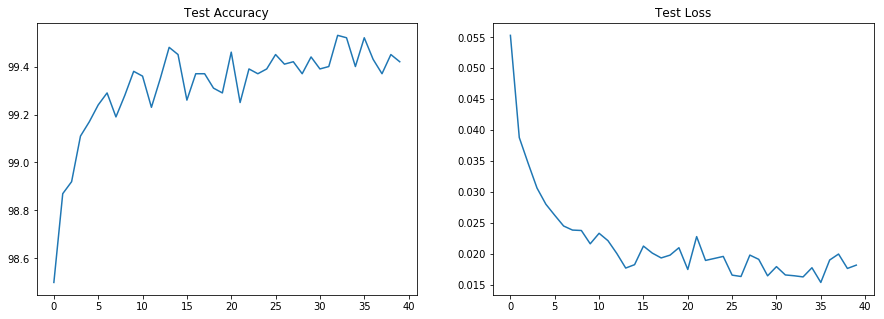

In [25]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_acc_l1_1_l2_0)
axs[0].set_title("Test Accuracy")
axs[1].plot(test_loss_l1_1_l2_0)
axs[1].set_title("Test Loss")

### an example load of  the  model with L1 alone
        - Once having saved as a file, these best model can be loaded anytime, by giving the name

In [26]:
model = load_model(Net2(), model_name='MNIST_model_epoch-33_L1-1_L2-0_val_acc-99.53.h5')

### confusion matrix & classification-report for this model prdection (L1 alone)
        - load the best model as above and get the predictions

In [27]:
y_test = test_mnist.test_labels.cpu().numpy()
y_pred = model_pred(model, device, y_test)

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1131    0    0    1    2    1    0    0    0]
 [   1    1 1028    0    0    0    0    2    0    0]
 [   0    0    0 1008    0    2    0    0    0    0]
 [   0    0    0    0  981    0    0    0    0    1]
 [   1    0    0    3    0  887    1    0    0    0]
 [   3    2    0    1    1    1  950    0    0    0]
 [   0    5    2    0    1    0    0 1020    0    0]
 [   0    1    1    0    0    1    0    0  970    1]
 [   0    1    0    0    7    0    0    2    0  999]]


              precision    recall  f1-score   support

        zero       0.99      1.00      1.00       980
         one       0.99      1.00      0.99      1135
         two       1.00      1.00      1.00      1032
       three       1.00      1.00      1.00      1010
        four       0.99      1.00      0.99       982
        five       0.99      0.99      0.99       892
         six       1.00      0.99      0.99       958
       seven       1.00      0.99 

### mislabelled images from the model with L1 alone
        - load the best model as above and get the predictions

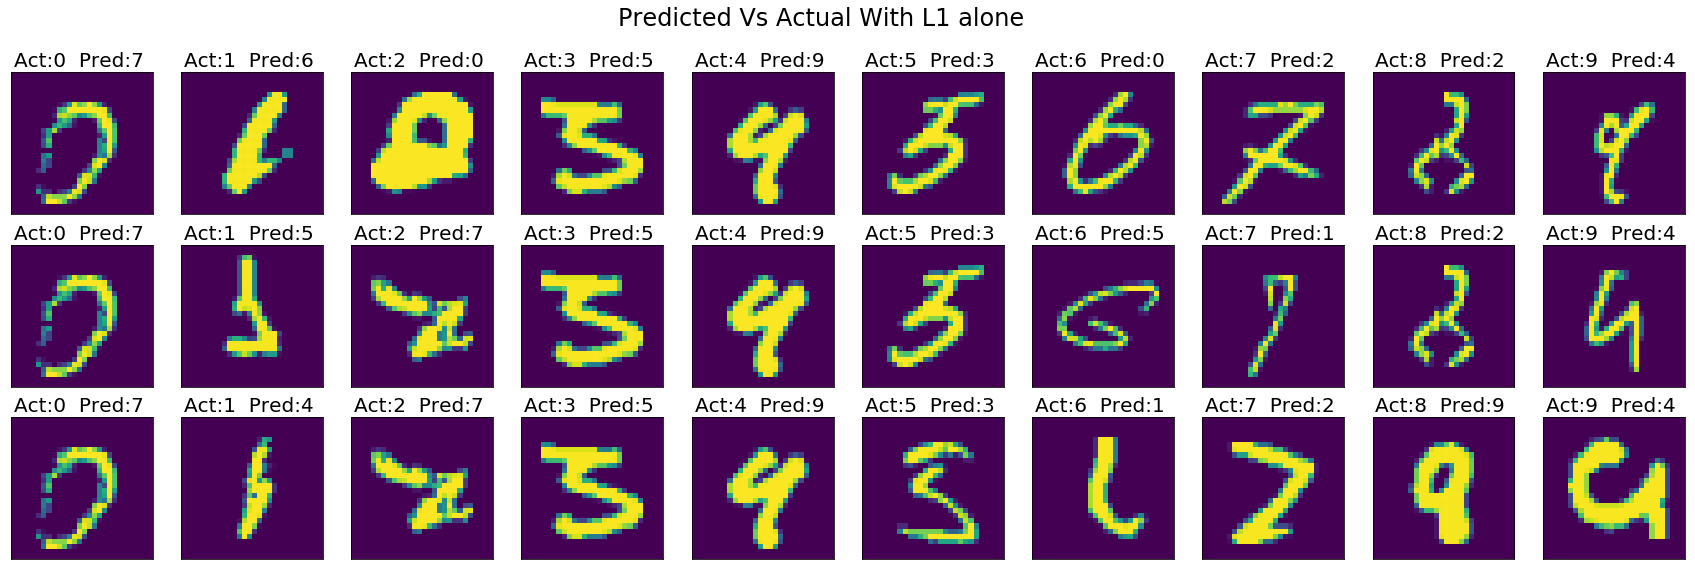

In [32]:
x_test = test_mnist.test_data.cpu().numpy()
display_mislabelled(model, device,  x_test, y_test.reshape(-1,1), y_pred, title_str='Predicted Vs Actual With L1 alone' )

# 3.  model,  40 epochs, with L2 alone

In [15]:
L1 = False #without L1-penalty 
L2 = True #with L2-penalty

#### Though the underlying structure of the models is same for all, am describing each as Net1(), Net2() etc to segregate

In [16]:
dropout_value = 0.1
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [17]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model3 = Net3().to(device)
summary(model3, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Let's Train and test our model

In [18]:
model3 =  Net3().to(device)
#Enable L2-regularization with supplied value of weight decay, or keep it default-0
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model3, device, train_loader, optimizer, epoch)
    test(model3, device, test_loader, epoch)

EPOCH: 1


Loss=0.17852485179901123 Batch_id=937 Accuracy=87.26: 100%|██████████████████████████| 938/938 [00:15<00:00, 59.10it/s]



Test set: Average loss: 0.0573, Accuracy: 9842/10000 (98.42%)

validation-accuracy improved from 0 to 98.42, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-1_L1-0_L2-1_val_acc-98.42.h5
EPOCH: 2


Loss=0.020696744322776794 Batch_id=937 Accuracy=97.36: 100%|█████████████████████████| 938/938 [00:16<00:00, 57.55it/s]



Test set: Average loss: 0.0385, Accuracy: 9880/10000 (98.80%)

validation-accuracy improved from 98.42 to 98.8, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-2_L1-0_L2-1_val_acc-98.8.h5
EPOCH: 3


Loss=0.21972578763961792 Batch_id=937 Accuracy=97.89: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.30it/s]



Test set: Average loss: 0.0330, Accuracy: 9898/10000 (98.98%)

validation-accuracy improved from 98.8 to 98.98, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-3_L1-0_L2-1_val_acc-98.98.h5
EPOCH: 4


Loss=0.022882893681526184 Batch_id=937 Accuracy=98.11: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.61it/s]



Test set: Average loss: 0.0330, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.06278645247220993 Batch_id=937 Accuracy=98.31: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.45it/s]



Test set: Average loss: 0.0283, Accuracy: 9920/10000 (99.20%)

validation-accuracy improved from 98.98 to 99.2, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-5_L1-0_L2-1_val_acc-99.2.h5
EPOCH: 6


Loss=0.0076937079429626465 Batch_id=937 Accuracy=98.42: 100%|████████████████████████| 938/938 [00:16<00:00, 56.06it/s]



Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

validation-accuracy improved from 99.2 to 99.23, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-6_L1-0_L2-1_val_acc-99.23.h5
EPOCH: 7


Loss=0.21159739792346954 Batch_id=937 Accuracy=98.55: 100%|██████████████████████████| 938/938 [00:16<00:00, 66.59it/s]



Test set: Average loss: 0.0264, Accuracy: 9926/10000 (99.26%)

validation-accuracy improved from 99.23 to 99.26, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-7_L1-0_L2-1_val_acc-99.26.h5
EPOCH: 8


Loss=0.0704844743013382 Batch_id=937 Accuracy=98.56: 100%|███████████████████████████| 938/938 [00:16<00:00, 54.26it/s]



Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.009236067533493042 Batch_id=937 Accuracy=98.58: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.94it/s]



Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.010971993207931519 Batch_id=937 Accuracy=98.66: 100%|█████████████████████████| 938/938 [00:16<00:00, 56.23it/s]



Test set: Average loss: 0.0253, Accuracy: 9931/10000 (99.31%)

validation-accuracy improved from 99.26 to 99.31, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-10_L1-0_L2-1_val_acc-99.31.h5
EPOCH: 11


Loss=0.01833927631378174 Batch_id=937 Accuracy=98.64: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.34it/s]



Test set: Average loss: 0.0245, Accuracy: 9932/10000 (99.32%)

validation-accuracy improved from 99.31 to 99.32, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-11_L1-0_L2-1_val_acc-99.32.h5
EPOCH: 12


Loss=0.08181887865066528 Batch_id=937 Accuracy=98.72: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.47it/s]



Test set: Average loss: 0.0251, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.02143838256597519 Batch_id=937 Accuracy=98.77: 100%|██████████████████████████| 938/938 [00:16<00:00, 63.58it/s]



Test set: Average loss: 0.0234, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.03831207752227783 Batch_id=937 Accuracy=98.83: 100%|██████████████████████████| 938/938 [00:17<00:00, 55.15it/s]



Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

validation-accuracy improved from 99.32 to 99.39, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-14_L1-0_L2-1_val_acc-99.39.h5
EPOCH: 15


Loss=0.16946956515312195 Batch_id=937 Accuracy=98.77: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.41it/s]



Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

validation-accuracy improved from 99.39 to 99.42, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-15_L1-0_L2-1_val_acc-99.42.h5
EPOCH: 16


Loss=0.036524251103401184 Batch_id=937 Accuracy=98.82: 100%|█████████████████████████| 938/938 [00:16<00:00, 64.24it/s]



Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.0028601884841918945 Batch_id=937 Accuracy=98.80: 100%|████████████████████████| 938/938 [00:16<00:00, 55.27it/s]



Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.059608638286590576 Batch_id=937 Accuracy=98.83: 100%|█████████████████████████| 938/938 [00:16<00:00, 64.27it/s]



Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.02769477665424347 Batch_id=937 Accuracy=98.81: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.36it/s]



Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.019431546330451965 Batch_id=937 Accuracy=98.83: 100%|█████████████████████████| 938/938 [00:16<00:00, 56.66it/s]



Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.015623286366462708 Batch_id=937 Accuracy=98.87: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.21it/s]



Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

validation-accuracy improved from 99.42 to 99.44, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-21_L1-0_L2-1_val_acc-99.44.h5
EPOCH: 22


Loss=0.006489947438240051 Batch_id=937 Accuracy=98.92: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.64it/s]



Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 23


Loss=0.0021987557411193848 Batch_id=937 Accuracy=98.96: 100%|████████████████████████| 938/938 [00:17<00:00, 53.20it/s]



Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.08592762053012848 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:18<00:00, 52.10it/s]



Test set: Average loss: 0.0203, Accuracy: 9932/10000 (99.32%)

EPOCH: 25


Loss=0.026391491293907166 Batch_id=937 Accuracy=98.94: 100%|█████████████████████████| 938/938 [00:17<00:00, 55.02it/s]



Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 26


Loss=0.003989845514297485 Batch_id=937 Accuracy=98.88: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.86it/s]



Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 27


Loss=0.11228375881910324 Batch_id=937 Accuracy=98.97: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.34it/s]



Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 28


Loss=0.034182220697402954 Batch_id=937 Accuracy=98.89: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.23it/s]



Test set: Average loss: 0.0214, Accuracy: 9941/10000 (99.41%)

EPOCH: 29


Loss=0.00528542697429657 Batch_id=937 Accuracy=98.94: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.51it/s]



Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 30


Loss=0.009978964924812317 Batch_id=937 Accuracy=98.98: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.41it/s]



Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 31


Loss=0.019636139273643494 Batch_id=937 Accuracy=98.92: 100%|█████████████████████████| 938/938 [00:16<00:00, 56.27it/s]



Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

EPOCH: 32


Loss=0.024349987506866455 Batch_id=937 Accuracy=98.94: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.05it/s]



Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

EPOCH: 33


Loss=0.0069541484117507935 Batch_id=937 Accuracy=98.95: 100%|████████████████████████| 938/938 [00:17<00:00, 54.44it/s]



Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 34


Loss=0.03022589534521103 Batch_id=937 Accuracy=98.96: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.32it/s]



Test set: Average loss: 0.0179, Accuracy: 9949/10000 (99.49%)

validation-accuracy improved from 99.44 to 99.49, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-34_L1-0_L2-1_val_acc-99.49.h5
EPOCH: 35


Loss=0.015299677848815918 Batch_id=937 Accuracy=99.00: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.46it/s]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 36


Loss=0.055514127016067505 Batch_id=937 Accuracy=98.96: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.59it/s]



Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)

EPOCH: 37


Loss=0.012462377548217773 Batch_id=937 Accuracy=98.98: 100%|█████████████████████████| 938/938 [00:17<00:00, 55.17it/s]



Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.0933474749326706 Batch_id=937 Accuracy=98.99: 100%|███████████████████████████| 938/938 [00:17<00:00, 54.55it/s]



Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 39


Loss=0.02958376705646515 Batch_id=937 Accuracy=99.00: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.46it/s]



Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 40


Loss=0.010105118155479431 Batch_id=937 Accuracy=99.00: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.21it/s]



Test set: Average loss: 0.0208, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

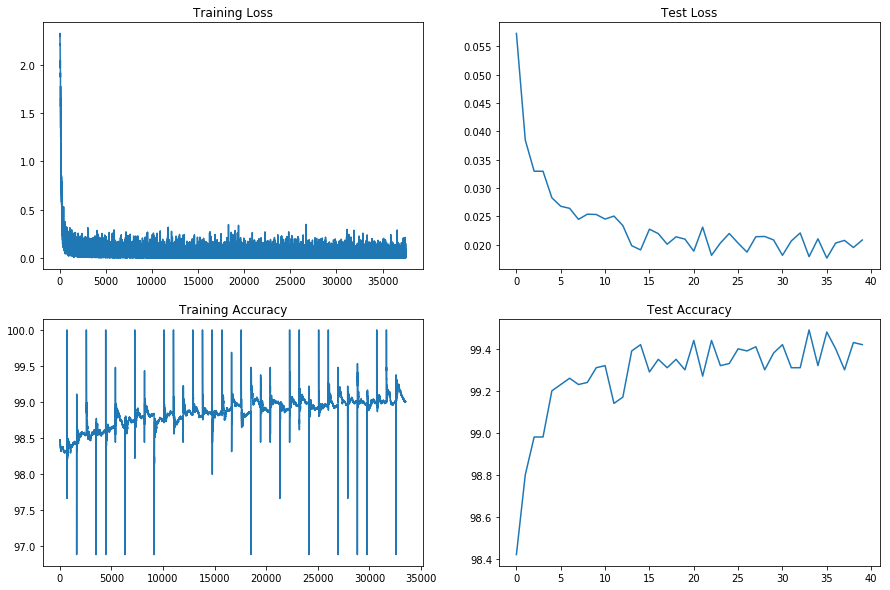

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### save the validation-accuracy & validation-loss data  for the  model with L2 alone

In [20]:
save_acc_loss(test_losses, 
              test_acc, 
              test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
              test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
             )

### an example load for the validation-accuracy & validation-loss data  for the  model with L2 alone
        - Once having saved as a file, these acc/loss values can be loaded anytime

In [21]:
#Load these data points later using code as below
test_loss_l1_0_l2_1, test_acc_l1_0_l2_1 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

Text(0.5, 1.0, 'Test Loss')

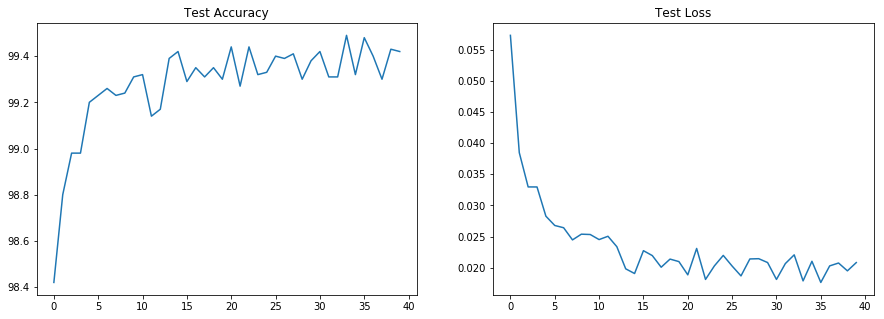

In [22]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_acc_l1_0_l2_1)
axs[0].set_title("Test Accuracy")
axs[1].plot(test_loss_l1_0_l2_1)
axs[1].set_title("Test Loss")

### an example load of  the  model with L2 alone
        - Once having saved as a file, these best model can be loaded anytime, by giving the name

In [23]:
model = load_model(Net3(), model_name='MNIST_model_epoch-34_L1-0_L2-1_val_acc-99.49.h5')

### confusion matrix & classification-report for this model prdection
        - load the best model as above and get the predictions

In [24]:
y_test = test_mnist.test_labels.cpu().numpy()
y_pred = model_pred(model, device, y_test)

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1132    0    0    0    2    0    1    0    0]
 [   0    0 1030    0    0    0    0    2    0    0]
 [   0    0    1 1004    0    5    0    0    0    0]
 [   0    0    0    0  976    0    0    2    0    4]
 [   0    0    0    2    0  889    1    0    0    0]
 [   3    5    0    0    2    1  947    0    0    0]
 [   0    3    4    0    0    0    0 1021    0    0]
 [   0    1    1    1    0    1    0    0  969    1]
 [   0    0    0    0    3    2    0    1    0 1003]]


              precision    recall  f1-score   support

        zero       1.00      1.00      1.00       980
         one       0.99      1.00      0.99      1135
         two       0.99      1.00      1.00      1032
       three       1.00      0.99      1.00      1010
        four       0.99      0.99      0.99       982
        five       0.99      1.00      0.99       892
         six       1.00      0.99      0.99       958
       seven       0.99      0.99 

### mislabelled images from the model with L2 alone
        - load the best model as above and get the predictions

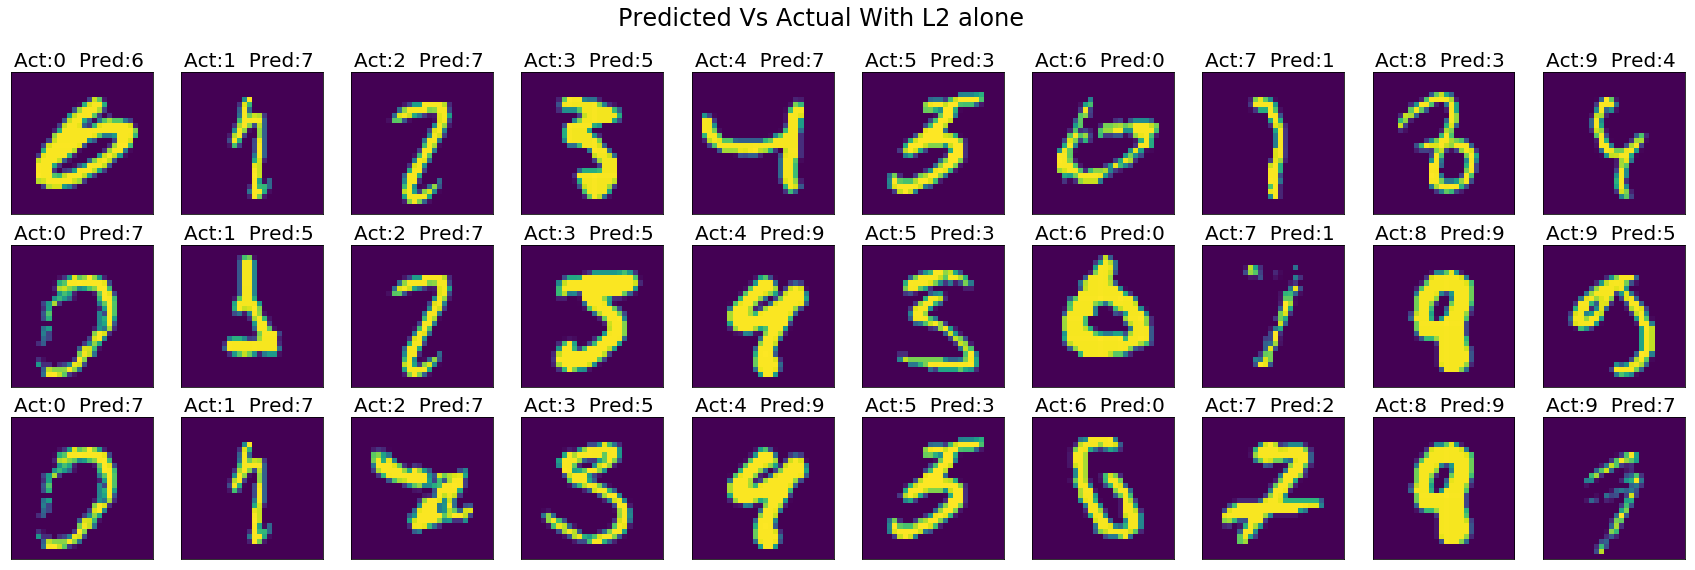

In [27]:
x_test = test_mnist.test_data.cpu().numpy()
display_mislabelled(model, device,  x_test, y_test.reshape(-1,1), y_pred, title_str='Predicted Vs Actual With L2 alone' )

# 4.  model,  40 epochs, with both L1 & L2

In [15]:
L1 = True #with L1-penalty 
L2 = True #with L2-penalty

#### Though the underlying structure of the models is same for all, am describing each as Net1(), Net2() etc to segregate

In [16]:
dropout_value = 0.1
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [18]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model4 = Net4().to(device)
summary(model4, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Let's Train and test our model

In [19]:
model4 =  Net4().to(device)
#Enable L2-regularization with supplied value of weight decay, or keep it default-0
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model4, device, train_loader, optimizer, epoch)
    test(model4, device, test_loader, epoch)

EPOCH: 1


Loss=0.17772150039672852 Batch_id=937 Accuracy=87.40: 100%|██████████████████████████| 938/938 [00:15<00:00, 66.54it/s]



Test set: Average loss: 0.0581, Accuracy: 9832/10000 (98.32%)

validation-accuracy improved from 0 to 98.32, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-1_L1-1_L2-1_val_acc-98.32.h5
EPOCH: 2


Loss=0.02024082839488983 Batch_id=937 Accuracy=97.39: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.91it/s]



Test set: Average loss: 0.0398, Accuracy: 9879/10000 (98.79%)

validation-accuracy improved from 98.32 to 98.79, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-2_L1-1_L2-1_val_acc-98.79.h5
EPOCH: 3


Loss=0.1958741545677185 Batch_id=937 Accuracy=97.90: 100%|███████████████████████████| 938/938 [00:16<00:00, 57.50it/s]



Test set: Average loss: 0.0342, Accuracy: 9894/10000 (98.94%)

validation-accuracy improved from 98.79 to 98.94, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-3_L1-1_L2-1_val_acc-98.94.h5
EPOCH: 4


Loss=0.016614407300949097 Batch_id=937 Accuracy=98.12: 100%|█████████████████████████| 938/938 [00:16<00:00, 57.46it/s]



Test set: Average loss: 0.0337, Accuracy: 9899/10000 (98.99%)

validation-accuracy improved from 98.94 to 98.99, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-4_L1-1_L2-1_val_acc-98.99.h5
EPOCH: 5


Loss=0.08880754560232162 Batch_id=937 Accuracy=98.29: 100%|██████████████████████████| 938/938 [00:16<00:00, 57.60it/s]



Test set: Average loss: 0.0294, Accuracy: 9912/10000 (99.12%)

validation-accuracy improved from 98.99 to 99.12, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-5_L1-1_L2-1_val_acc-99.12.h5
EPOCH: 6


Loss=0.009920090436935425 Batch_id=937 Accuracy=98.38: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.80it/s]



Test set: Average loss: 0.0276, Accuracy: 9924/10000 (99.24%)

validation-accuracy improved from 99.12 to 99.24, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-6_L1-1_L2-1_val_acc-99.24.h5
EPOCH: 7


Loss=0.20912328362464905 Batch_id=937 Accuracy=98.46: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.13it/s]



Test set: Average loss: 0.0302, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.0826663225889206 Batch_id=937 Accuracy=98.54: 100%|███████████████████████████| 938/938 [00:15<00:00, 61.04it/s]



Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.005694374442100525 Batch_id=937 Accuracy=98.56: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.45it/s]



Test set: Average loss: 0.0258, Accuracy: 9925/10000 (99.25%)

validation-accuracy improved from 99.24 to 99.25, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-9_L1-1_L2-1_val_acc-99.25.h5
EPOCH: 10


Loss=0.011975094676017761 Batch_id=937 Accuracy=98.66: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.77it/s]



Test set: Average loss: 0.0264, Accuracy: 9928/10000 (99.28%)

validation-accuracy improved from 99.25 to 99.28, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-10_L1-1_L2-1_val_acc-99.28.h5
EPOCH: 11


Loss=0.035380423069000244 Batch_id=937 Accuracy=98.63: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.78it/s]



Test set: Average loss: 0.0275, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.08031889796257019 Batch_id=937 Accuracy=98.71: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.05it/s]



Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.008773714303970337 Batch_id=937 Accuracy=98.72: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.53it/s]



Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

validation-accuracy improved from 99.28 to 99.29, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-13_L1-1_L2-1_val_acc-99.29.h5
EPOCH: 14


Loss=0.03345125913619995 Batch_id=937 Accuracy=98.75: 100%|██████████████████████████| 938/938 [00:16<00:00, 65.16it/s]



Test set: Average loss: 0.0198, Accuracy: 9945/10000 (99.45%)

validation-accuracy improved from 99.29 to 99.45, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-14_L1-1_L2-1_val_acc-99.45.h5
EPOCH: 15


Loss=0.17655763030052185 Batch_id=937 Accuracy=98.77: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.77it/s]



Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.03455705940723419 Batch_id=937 Accuracy=98.80: 100%|██████████████████████████| 938/938 [00:17<00:00, 55.15it/s]



Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.0028544217348098755 Batch_id=937 Accuracy=98.82: 100%|████████████████████████| 938/938 [00:17<00:00, 55.01it/s]



Test set: Average loss: 0.0257, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.08832598477602005 Batch_id=937 Accuracy=98.81: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.76it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.02885948121547699 Batch_id=937 Accuracy=98.87: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.97it/s]



Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.025519639253616333 Batch_id=937 Accuracy=98.80: 100%|█████████████████████████| 938/938 [00:16<00:00, 63.64it/s]



Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.01853354275226593 Batch_id=937 Accuracy=98.83: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.59it/s]



Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.009525686502456665 Batch_id=937 Accuracy=98.90: 100%|█████████████████████████| 938/938 [00:17<00:00, 55.12it/s]



Test set: Average loss: 0.0255, Accuracy: 9925/10000 (99.25%)

EPOCH: 23


Loss=0.004401668906211853 Batch_id=937 Accuracy=98.94: 100%|█████████████████████████| 938/938 [00:17<00:00, 55.01it/s]



Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.06446592509746552 Batch_id=937 Accuracy=98.85: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.32it/s]



Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 25


Loss=0.03049042820930481 Batch_id=937 Accuracy=98.92: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.93it/s]



Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

EPOCH: 26


Loss=0.004094749689102173 Batch_id=937 Accuracy=98.85: 100%|█████████████████████████| 938/938 [00:16<00:00, 63.45it/s]



Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 27


Loss=0.11666816473007202 Batch_id=937 Accuracy=98.96: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.38it/s]



Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 28


Loss=0.018482685089111328 Batch_id=937 Accuracy=98.94: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.75it/s]



Test set: Average loss: 0.0221, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.00815322995185852 Batch_id=937 Accuracy=98.95: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.01it/s]



Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 30


Loss=0.005224153399467468 Batch_id=937 Accuracy=98.93: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.62it/s]



Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 31


Loss=0.015401989221572876 Batch_id=937 Accuracy=98.90: 100%|█████████████████████████| 938/938 [00:16<00:00, 55.21it/s]



Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 32


Loss=0.029133543372154236 Batch_id=937 Accuracy=98.97: 100%|█████████████████████████| 938/938 [00:17<00:00, 55.09it/s]



Test set: Average loss: 0.0230, Accuracy: 9919/10000 (99.19%)

EPOCH: 33


Loss=0.02457420527935028 Batch_id=937 Accuracy=98.94: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.31it/s]



Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 34


Loss=0.04710549861192703 Batch_id=937 Accuracy=98.97: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.19it/s]



Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

validation-accuracy improved from 99.45 to 99.48, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-34_L1-1_L2-1_val_acc-99.48.h5
EPOCH: 35


Loss=0.01523427665233612 Batch_id=937 Accuracy=99.02: 100%|██████████████████████████| 938/938 [00:17<00:00, 62.54it/s]



Test set: Average loss: 0.0218, Accuracy: 9928/10000 (99.28%)

EPOCH: 36


Loss=0.10866744071245193 Batch_id=937 Accuracy=98.98: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.59it/s]



Test set: Average loss: 0.0186, Accuracy: 9950/10000 (99.50%)

validation-accuracy improved from 99.48 to 99.5, saving model to D:\PG-ML\eva4\week6\saved_models\MNIST_model_epoch-36_L1-1_L2-1_val_acc-99.5.h5
EPOCH: 37


Loss=0.027625322341918945 Batch_id=937 Accuracy=98.97: 100%|█████████████████████████| 938/938 [00:16<00:00, 56.10it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 38


Loss=0.08488093316555023 Batch_id=937 Accuracy=98.96: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.55it/s]



Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH: 39


Loss=0.04474624991416931 Batch_id=937 Accuracy=98.93: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.43it/s]



Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 40


Loss=0.014934495091438293 Batch_id=937 Accuracy=99.00: 100%|█████████████████████████| 938/938 [00:15<00:00, 70.48it/s]



Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

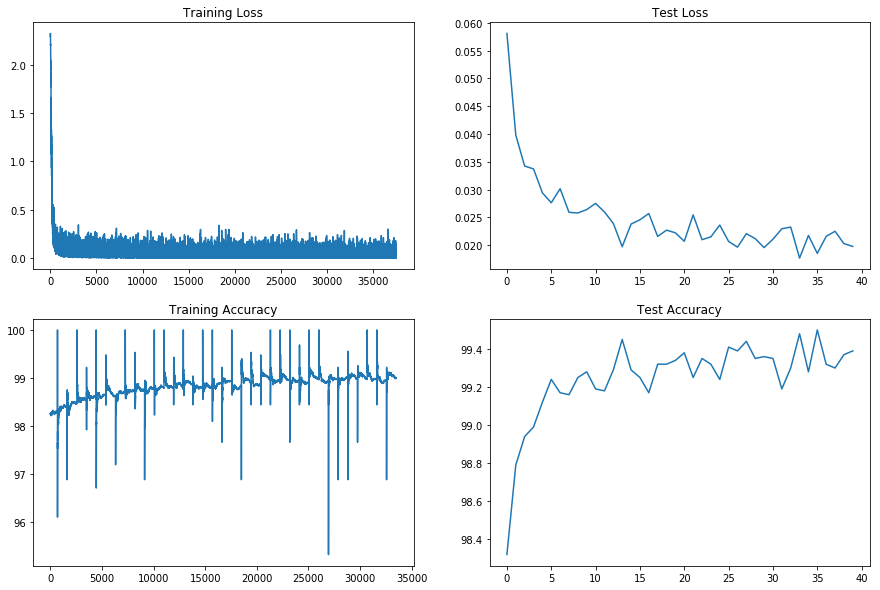

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### save the validation-accuracy & validation-loss data  for the  model with both L1 & L2

In [21]:
save_acc_loss(test_losses, 
              test_acc, 
              test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
              test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
             )

### an example load for the validation-accuracy & validation-loss data  for the  model with both L1 & L2
        - Once having saved as a file, these acc/loss values can be loaded anytime

In [22]:
#Load these data points later using code as below
test_loss_l1_1_l2_1, test_acc_l1_1_l2_1 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

Text(0.5, 1.0, 'Test Loss')

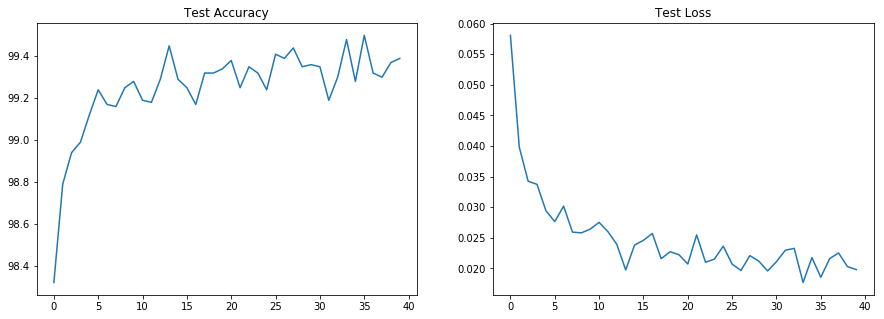

In [23]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_acc_l1_1_l2_1)
axs[0].set_title("Test Accuracy")
axs[1].plot(test_loss_l1_1_l2_1)
axs[1].set_title("Test Loss")

### an example load of  the  model with both L1 & L2
        - Once having saved as a file, these best model can be loaded anytime, by giving the name

In [24]:
model = load_model(Net4(), model_name='MNIST_model_epoch-36_L1-1_L2-1_val_acc-99.5.h5')

### confusion matrix & classification-report for this model prdection
        - load the best model as above and get the predictions

In [25]:
y_test = test_mnist.test_labels.cpu().numpy()
y_pred = model_pred(model, device, y_test)

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1132    1    1    0    0    0    1    0    0]
 [   0    0 1026    0    0    0    0    5    1    0]
 [   0    0    0 1006    0    4    0    0    0    0]
 [   0    0    0    0  977    0    0    0    0    5]
 [   0    0    0    3    0  888    1    0    0    0]
 [   2    3    0    0    1    1  951    0    0    0]
 [   0    3    3    0    0    1    0 1021    0    0]
 [   0    0    1    0    2    1    0    0  969    1]
 [   0    0    0    0    5    1    0    2    0 1001]]


              precision    recall  f1-score   support

        zero       1.00      1.00      1.00       980
         one       0.99      1.00      1.00      1135
         two       1.00      0.99      0.99      1032
       three       1.00      1.00      1.00      1010
        four       0.99      0.99      0.99       982
        five       0.99      1.00      0.99       892
         six       1.00      0.99      1.00       958
       seven       0.99      0.99 

### mislabelled images from the model with both L1 & L2
        - load the best model as above and get the predictions

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


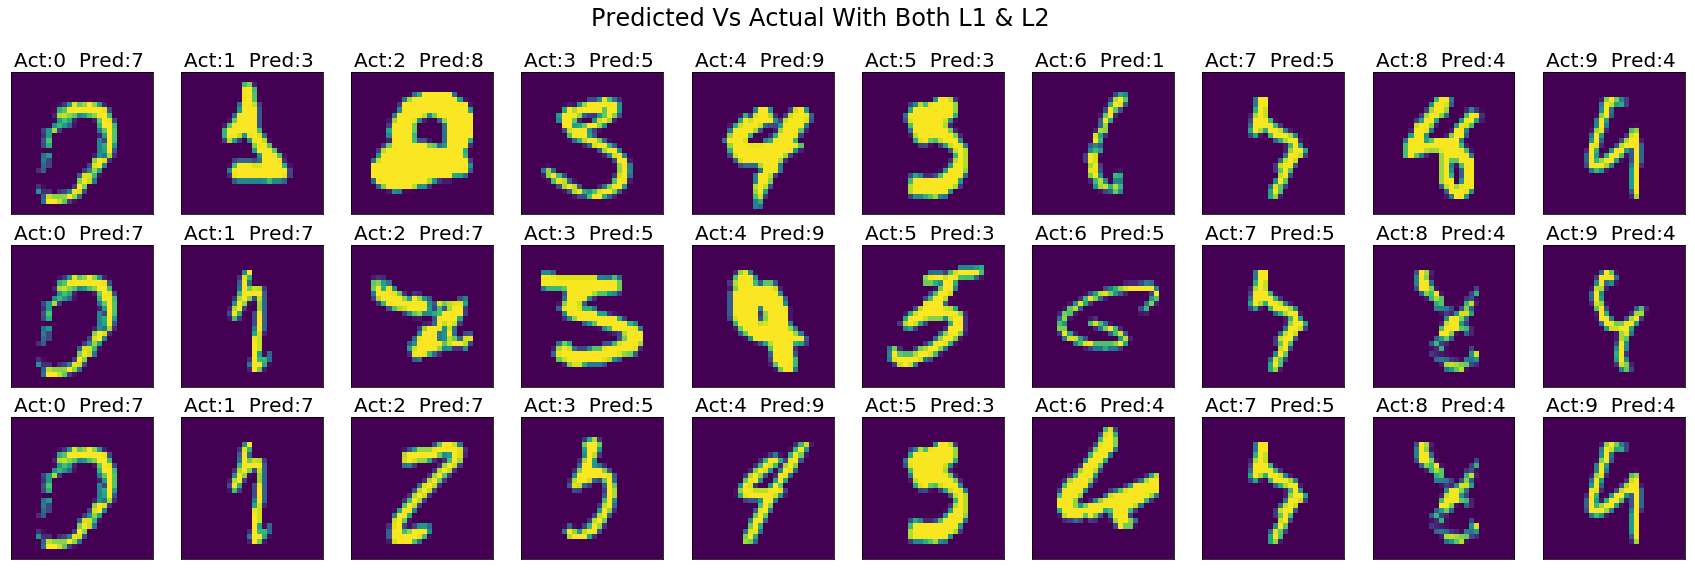

In [26]:
x_test = test_mnist.test_data.cpu().numpy()
display_mislabelled(model, device,  x_test, y_test.reshape(-1,1), y_pred, title_str='Predicted Vs Actual With Both L1 & L2' )

### Plot 2 curves: one with test accuracies for all above 4 cases & another with test-loss for all.

##### load validation-accuracy & validation-loss data  for the  model without L1/L2

In [27]:
L1 = False #without L1-penalty 
L2 = False #without L2-penalty
#Load these data points later using code as below
test_loss_l1_0_l2_0, test_acc_l1_0_l2_0 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

##### load validation-accuracy & validation-loss data  for the  model with L1 alone

In [28]:
L1 = True #with L1-penalty 
L2 = False #without L2-penalty
#Load these data points later using code as below
test_loss_l1_1_l2_0, test_acc_l1_1_l2_0 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

##### load validation-accuracy & validation-loss data  for the  model with L2 alone

In [29]:
L1 = False #without L1-penalty 
L2 = True #with L2-penalty
#Load these data points later using code as below
test_loss_l1_0_l2_1, test_acc_l1_0_l2_1 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

##### load validation-accuracy & validation-loss data  for the  model with both L1 & L2

In [30]:
L1 = True #with L1-penalty 
L2 = True #with L2-penalty
#Load these data points later using code as below
test_loss_l1_1_l2_1, test_acc_l1_1_l2_1 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

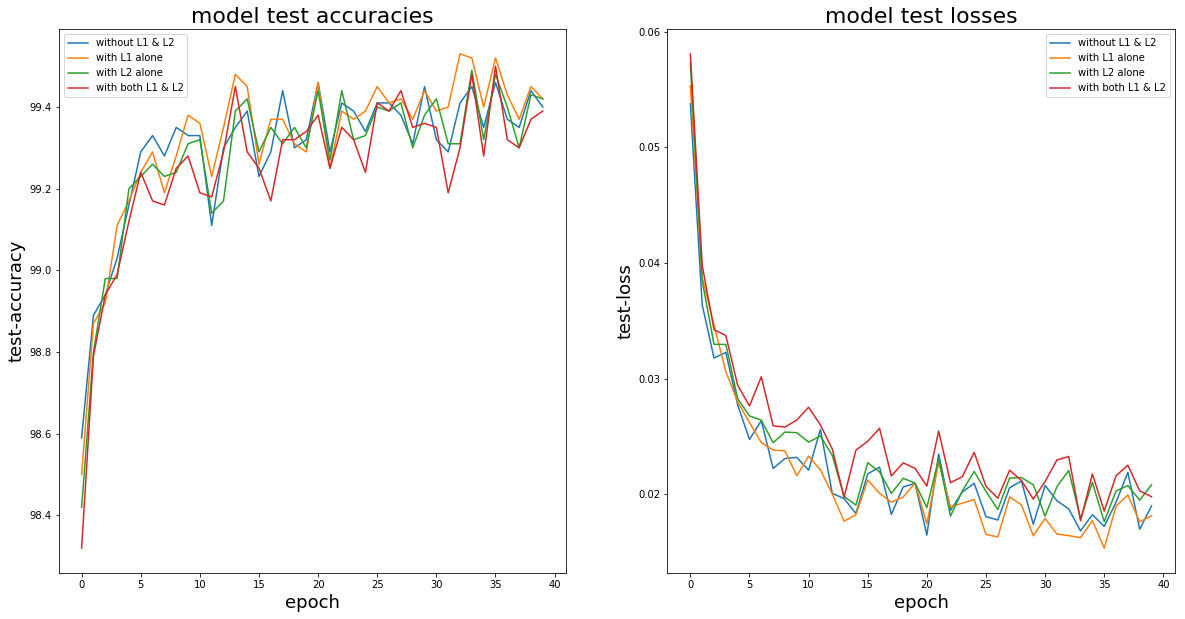

In [41]:
plot_curves(test_acc_l1_0_l2_0, test_acc_l1_1_l2_0, test_acc_l1_0_l2_1, test_acc_l1_1_l2_1,
                test_loss_l1_0_l2_0, test_loss_l1_1_l2_0, test_loss_l1_0_l2_1, test_loss_l1_1_l2_1)